In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# CFPS2012

In [22]:
# 成人问卷
df1=pd.read_sas('CFPS2012/cfps2012adult_201906.sas7bdat')
df1['pid']=df1['pid'].astype(int)
# 家庭成员关系
# 需要从中识别父亲编号pid_f，再去成人问卷中匹配父亲pid
df2=pd.read_sas('CFPS2012/cfps2012famconf_092015.sas7bdat')
df2[['pid','pid_f']]=df2[['pid','pid_f']].astype(int)
# 2016跨年数据
df3=pd.read_sas('CFPS2016/cfps2016crossyearid_201807.sas7bdat')
df3['pid']=df3['pid'].astype(int)
# 2012跨年数据
# df4=pd.read_sas('CFPS2012/crossyearid_032015.sas7bdat')
# df4['pid']=df4['pid'].astype(int)

In [23]:
# describe后发现id有为负数的，视作异常样本
# df1剔除id不在区间范围的记录
# 删除0条
out_df1=np.where((df1.pid<105179433)|(df1.pid>997150431))[0]
df1.drop(out_df1,inplace=True)
df1.reset_index(drop=True,inplace=True)# 剩35719

# df2剔除pid_f等于-8的样本的记录
# 删除32667
out_df2=np.where((df2.pid<100453401)|(df2.pid>997150433))[0] # 查看后有4条重复记录
index1=np.where((df2.pid_f==-8))[0]
df2_1=df2.drop(list(out_df2)+list(index1))
df2_1.reset_index(drop=True,inplace=True)
# 筛选所需变量
df2_2=df2_1[['pid','pid_f','TB4_A12_p','TB4_A12_f']] # 剩21508

In [24]:
# 查看有无id重复记录
df1[df1.pid.duplicated(keep=False)]# 无重复
df2_2[df2_2.duplicated(subset=['pid','pid_f'],keep=False)]# 无重复
df2_2.drop_duplicates(subset=['pid','pid_f'],keep='first',inplace=True)# 剩21508

c:\users\yirav\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [25]:
# 数据匹配，需要匹配两次，分别获取个人详细信息和父亲详细信息
# 获取个人信息
# 先匹配跨年库中的相关变量
df1=pd.merge(df1,df3[['pid','INCOME_12','INCOME_ADJ_12','cfps2012edu',
'cfps2012eduy','cfps2012eduy_im']],on='pid',how='left')
'''
qa301：现在的户口状况
wc01：上学状态
employ：当前工作状态
QN401_S_1：您是哪些组织成员，党员为1，其余的后面设为0，剔除缺失
QP201：健康状况
edu2012：最高学历
eduy2012:受教育年限
cfps2012edu:最高学历
cfps2012eduy：受教育年限(2012跨年库中)
cfps2012eduy_im：受教育年限插补
income：总收入
'''
df1_1=df1[['pid','provcd','urban12','CFPS2012_AGE','CFPS2012_GENDER','QN401_S_1',
           'QA301','WC01','EMPLOY','QP201','edu2012','eduy2012','INCOME','income_adj',
          'INCOME_12','INCOME_ADJ_12','cfps2012edu','cfps2012eduy','cfps2012eduy_im']]
merge1=pd.merge(df1_1,df2_2,on='pid')
merge1.rename(columns={'pid_f':'fpid'},inplace=True)# 避免merge产生重复列
# 获取父亲信息
merge2=pd.merge(merge1,df1_1,left_on='fpid',right_on='pid',suffixes=['_p','_f'])
merge2.drop(['fpid'],axis=1,inplace=True)
# 将列名全改为小写，方便后续操作
for x in merge2.columns.values:
    merge2.rename(columns={x:x.lower()},inplace=True)
# 匹配了8313
merge2.head()

,pid_p,provcd_p,urban12_p,cfps2012_age_p,cfps2012_gender_p,qn401_s_1_p,qa301_p,wc01_p,employ_p,qp201_p,...,qp201_f,edu2012_f,eduy2012_f,income_f,income_adj_f,income_12_f,income_adj_12_f,cfps2012edu_f,cfps2012eduy_f,cfps2012eduy_im_f
0,110009105,11.0,1.0,28.0,1.0,78.0,3.0,0.0,1.0,3.0,...,2.0,4.0,12.0,15000.0,15000.0,15000.0,15000.0,4.0,12.0,12.0
1,110009107,11.0,1.0,23.0,1.0,78.0,3.0,0.0,0.0,3.0,...,4.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,6.0
2,110013103,11.0,1.0,18.0,1.0,6.0,3.0,1.0,8.0,4.0,...,3.0,3.0,9.0,26000.0,26000.0,26000.0,26000.0,3.0,9.0,9.0
3,110015107,11.0,1.0,24.0,1.0,78.0,3.0,0.0,8.0,2.0,...,4.0,4.0,12.0,30000.0,30000.0,30000.0,30000.0,4.0,12.0,12.0
4,110020103,11.0,1.0,44.0,1.0,78.0,3.0,0.0,8.0,4.0,...,3.0,2.0,6.0,38400.0,38400.0,38400.0,38400.0,2.0,8.0,8.0


In [26]:
len(merge2)

8313

In [27]:
# 筛选子辈年龄16-45,父辈年龄36-65,父子年龄差小于16(异常样本) 暂定这个范围
res1=merge2
index2=np.where((res1.cfps2012_age_p<16)|(res1.cfps2012_age_p>45))[0]
index3=np.where((res1.cfps2012_age_f<36)|(res1.cfps2012_age_f>65))[0]
res1['age_dif']=res1['cfps2012_age_f']-res1['cfps2012_age_p']
index4=np.where(res1['age_dif']<10)[0]
res2=res1.drop(list(index2)+list(index3)+list(index4))
# 剩余7195
res2.reset_index(drop=True,inplace=True)

In [29]:
# 筛选已离开学校wc01_p=0，不要在职学生的数据（数据量比较小，且收入误差可能较大）
# school employ
# 注意需要用& |,用and,or会报错,&的优先级比==高,
index5=np.where((res2.wc01_p==0) & (res2.employ_p==1))[0]
res3=res2.loc[index5,:]
# 剩余5423
res3.reset_index(drop=True,inplace=True)

In [32]:
# 用2016跨年库中的income_adj_12对收入进行插补
res3['income_adj_p']=res3.apply(lambda x:x['income_adj_12_p'] if ((np.isnan(x['income_adj_p']))|(x['income_adj_p']==-8)|(x['income_adj_p']==0))
                            else x['income_adj_p'],axis=1)
res3['income_adj_f']=res3.apply(lambda x:x['income_adj_12_f'] if ((np.isnan(x['income_adj_f']))|(x['income_adj_f']==-8)|(x['income_adj_f']==0))
                            else x['income_adj_f'],axis=1)

In [33]:
# 剔除收入为空，或为-8,0的样本数据，以income_adj为标准
# 由于income_adj数据质量更好，使用该变量，删除income，并将income_adj进行更名
res3.drop(['income_p','income_f'],axis=1,inplace=True)
res3.rename(columns={'income_adj_p':'income_p','income_adj_f':'income_f'},inplace=True)
res4=res3.dropna(subset=['income_p','income_f']).reset_index(drop=True) # 剔除缺失值
index7=np.where((res4['income_p'].isin([-8,0]))|(res4['income_f'].isin([-8,0])))[0] # 剔除收入不适用和为0的数据
# index7=np.where((res4['income_p']==-8)|(res4['income_f']==-8))[0]
res5=res4.drop(index7) # 剩1617
res5.reset_index(drop=True,inplace=True)

In [35]:
len(res5)

1617

In [40]:
def eduy(x):
    if x==1:
        return 0
    elif x==2:
        return 6
    elif x==3:
        return 9
    elif x==4:
        return 12
    elif x==5:
        return 15
    elif x==6:
        return 16
    elif x==7:
        return 19
    elif x==8:
        return 22

In [60]:
# 查看学历是否需要插补
# 先把所有-9（缺失）替换为NA
# 插补后记得剔除edu为0的，表示没有数据
res6=res5.copy()
res6['eduy2012_p']=res6.apply(lambda x:x['cfps2012eduy_im_p'] if x['cfps2012eduy_im_p']>x['eduy2012_p'] else x['eduy2012_p'],axis=1)
res6['eduy2012_f']=res6.apply(lambda x:x['cfps2012eduy_im_f'] if x['cfps2012eduy_im_f']>x['eduy2012_f'] else x['eduy2012_f'],axis=1)
res6['edu2012_p']=res6.apply(lambda x:x['cfps2012edu_p'] if x['cfps2012edu_p']>x['edu2012_p'] else x['edu2012_p'],axis=1)
res6['edu2012_f']=res6.apply(lambda x:x['cfps2012edu_f'] if x['cfps2012edu_f']>x['edu2012_f'] else x['edu2012_f'],axis=1)
res6['edu2012_p']=res6.apply(lambda x:x['tb4_a12_p'] if ((np.isnan(x['edu2012_p']))|(x['edu2012_p']==-1)) else x['edu2012_p'],axis=1)
res6['edu2012_f']=res6.apply(lambda x:x['tb4_a12_f'] if ((np.isnan(x['edu2012_f']))|(x['edu2012_f']==-1)) else x['edu2012_f'],axis=1)
res6['eduy2012_p']=res6.apply(lambda x:eduy(x['edu2012_p']) if ((np.isnan(x['eduy2012_p']))|(x['eduy2012_p']==-1)) else x['eduy2012_p'],axis=1)
res6['eduy2012_f']=res6.apply(lambda x:eduy(x['edu2012_f']) if ((np.isnan(x['eduy2012_f']))|(x['eduy2012_f']==-1)) else x['eduy2012_f'],axis=1)
res6.drop(['cfps2012eduy_im_p','cfps2012eduy_im_f','cfps2012edu_p','cfps2012edu_f','cfps2012eduy_p','cfps2012eduy_f'],axis=1,inplace=True)

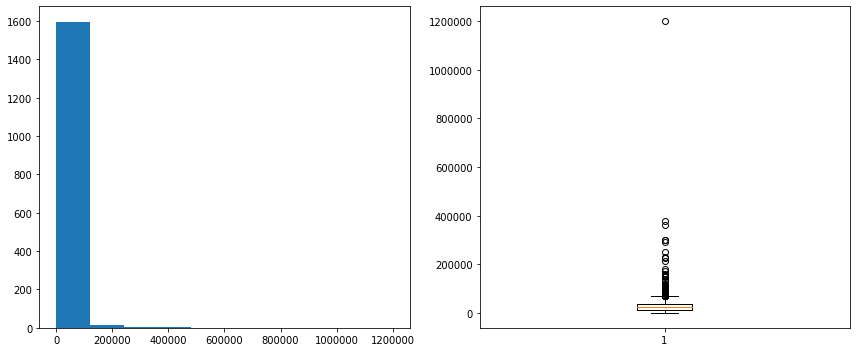

In [36]:
# 子代收入分布情况
fig_p = plt.figure(figsize=(12,5))
ax1_p = fig_p.add_subplot(121)
ax2_p=fig_p.add_subplot(122)
ax1_p.hist(res5['income_p'],bins=10)
ax2_p.boxplot(res5['income_p'])
fig_p.tight_layout()
plt.show()

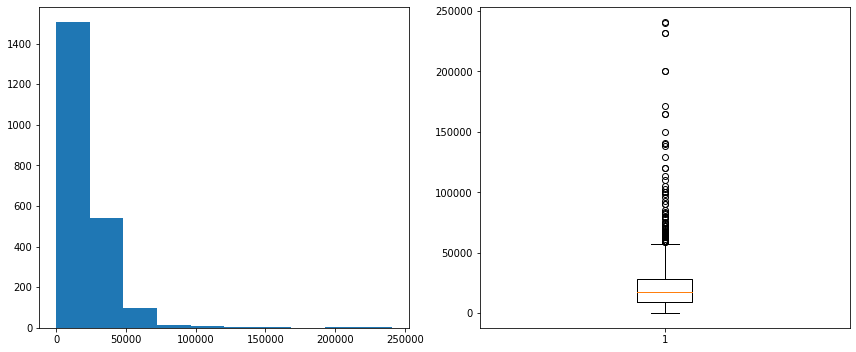

In [35]:
# 父代收入分布情况
fig_f = plt.figure(figsize=(12,5))
ax1_f = fig_f.add_subplot(121)
ax2_f=fig_f.add_subplot(122)
ax1_f.hist(res5['income_f'],bins=10)
ax2_f.boxplot(res5['income_f'])
fig_f.tight_layout()
plt.show()

In [61]:
# 计算收入的分位数
tmp_inp=np.array(res5['income_p'])
tmp_inf=np.array(res5['income_f'])
per_p=[np.percentile(tmp_inp,x) for x in [100,99,95,90,75,50,25,10,5,1,0]]
per_f=[np.percentile(tmp_inf,x) for x in [100,99,95,90,75,50,25,10,5,1,0]]
col_name=['100%max','99%','95%','90%','75%','50%','25%','10%','5%','1%','0%min']
pd.DataFrame([per_p,per_f],columns=col_name)

,100%max,99%,95%,90%,75%,50%,25%,10%,5%,1%,0%min
0,1200000.0,152150.4,72080.0,55000.0,36960.0,24000.0,15056.0,8000.0,4000.0,1200.0,1.0
1,241092.0,104958.4,54336.0,40859.2,30000.0,18120.0,10000.0,4000.0,2000.0,732.8,4.0


In [37]:
# 剔除首尾1%的极端数据，89条
# index8=np.where((res5.income_p<=np.percentile(tmp_inp,1))|(res5.income_p>=np.percentile(tmp_inp,99))|
#                (res5.income_f<=np.percentile(tmp_inf,1))|(res5.income_f>=np.percentile(tmp_inf,99)))[0]
# res6=res5.drop(index8)# 剩2091
# res6.reset_index(drop=True,inplace=True)

In [53]:
len(res6)

1617

In [62]:
res6.filter(regex='edu').describe()

,edu2012_p,eduy2012_p,edu2012_f,eduy2012_f
count,1617.000000,1617.000000,1617.000000,1617.000000
mean,3.672233,11.126160,2.605442,7.840445
std,1.319664,3.315343,1.116448,3.760368
min,1.000000,0.000000,1.000000,0.000000
25%,3.000000,9.000000,2.000000,6.000000
50%,3.000000,11.000000,3.000000,9.000000
75%,5.000000,15.000000,3.000000,9.000000
max,7.000000,19.000000,6.000000,16.000000


In [70]:
res7.columns.values.tolist()

['pid_p',
 'provcd_p',
 'urban12_p',
 'cfps2012_age_p',
 'cfps2012_gender_p',
 'qn401_s_1_p',
 'qa301_p',
 'wc01_p',
 'employ_p',
 'qp201_p',
 'edu2012_p',
 'eduy2012_p',
 'income_p',
 'tb4_a12_p',
 'tb4_a12_f',
 'pid_f',
 'provcd_f',
 'urban12_f',
 'cfps2012_age_f',
 'cfps2012_gender_f',
 'qn401_s_1_f',
 'qa301_f',
 'wc01_f',
 'employ_f',
 'qp201_f',
 'edu2012_f',
 'eduy2012_f',
 'income_f',
 'age_dif',
 'year']

In [117]:
# 根据其他相关变量剔除样本，包括缺失、不适用等
res7=res6.dropna(subset=['provcd_p','provcd_f','urban12_p','urban12_f','qa301_p','qa301_f',
                         'edu2012_p','edu2012_f','eduy2012_p','eduy2012_f','cfps2012_gender_p','cfps2012_gender_f',
                         'qp201_p','qp201_f','qn401_s_1_p','qn401_s_1_f']).reset_index(drop=True)
index9=np.where((res7.urban12_p==-9)|(res7.urban12_f==-9)|(res7.provcd_p==-9)|(res7.provcd_f==-9)|
            (res7.qa301_p.isin([-1,-2,5,79]))|(res7.qa301_f.isin([-1,-2,5,79]))|(res7.cfps2012_gender_p==-8)|
            (res7.cfps2012_gender_f==-8)|(res7.qn401_s_1_p.isin([-1,-8]))|(res7.qn401_s_1_p.isin([-1,-8]))|
            (res7.qp201_p.isin([-1,-2,-8]))|(res7.qp201_f.isin([-1,-2,-8])))[0]
res7.drop(index9,inplace=True)
res7.reset_index(drop=True,inplace=True)# 剩1070
res7['year']=2012

In [118]:
# 处理政治身份，党员为1，其余为0
res7['qn401_s_1_p']=res7.apply(lambda x:1 if x['qn401_s_1_p']==1 else 0,axis=1)
res7['qn401_s_1_f']=res7.apply(lambda x:1 if x['qn401_s_1_f']==1 else 0,axis=1)

In [119]:
len(res7)

1313

In [102]:
res7.groupby('provcd_p')['pid_p'].size()

provcd_p
11.0     11
12.0     12
13.0     76
14.0     57
21.0    115
22.0     18
23.0     31
31.0    148
32.0     47
33.0     31
34.0     34
35.0     19
36.0     28
37.0     58
41.0    216
42.0     15
43.0     34
44.0    129
45.0     21
50.0      7
51.0     45
52.0     18
53.0     27
61.0     22
62.0     94
Name: pid_p, dtype: int64

In [120]:
# 计算收入阶层
def per_num(x,tmp):
    '''
    x:income
    tmp:array(income)
    '''
    if x<=np.percentile(tmp,20):
        return 1
    elif np.percentile(tmp,20)<x<=np.percentile(tmp,40):
        return 2
    elif np.percentile(tmp,40)<x<=np.percentile(tmp,60):
        return 3
    elif np.percentile(tmp,60)<x<=np.percentile(tmp,80):
        return 4
    else:
        return 5

res7['rank_p']=res7['income_p'].map(lambda x:per_num(x,tmp_inp))
res7['rank_f']=res7['income_f'].map(lambda x:per_num(x,tmp_inf))
# 收入阶层流动
res7['rank_flow']=res7.apply(lambda x:1 if x['rank_p']>x['rank_f'] else (-1 if x['rank_p']<x['rank_f'] else 0),axis=1)

In [121]:
res7.groupby('rank_p')['pid_p'].size()

rank_p
1    270
2    262
3    249
4    281
5    251
Name: pid_p, dtype: int64

In [77]:
res7.groupby('rank_f')['pid_f'].size()

rank_f
1    246
2    294
3    232
4    267
5    274
Name: pid_f, dtype: int64

In [78]:
res7.groupby('rank_flow').size()

rank_flow
-1    503
 0    325
 1    485
dtype: int64

In [79]:
res7.groupby('urban12_f').size()

urban12_f
0.0    644
1.0    669
dtype: int64

In [116]:
res7.columns.values.tolist()

['pid_p',
 'provcd_p',
 'urban_p',
 'age_p',
 'gender_p',
 'party_p',
 'hukou_p',
 'school_p',
 'employ_p',
 'heal_p',
 'edu_p',
 'eduy_p',
 'income_p',
 'pid_f',
 'provcd_f',
 'urban_f',
 'age_f',
 'gender_f',
 'party_f',
 'hukou_f',
 'school_f',
 'employ_f',
 'heal_f',
 'edu_f',
 'eduy_f',
 'income_f',
 'age_dif',
 'year',
 'rank_p',
 'rank_f',
 'rank_flow',
 'rank_dif',
 'p_city_pro',
 'expend_farm_pro',
 'expend_edu_pro',
 'exp_GDP_pro',
 'birth_rate',
 'pGDP',
 'cpi']

In [122]:
res7.rename(columns={'urban12_p':'urban_p','urban12_f':'urban_f','cfps2012_age_p':'age_p',
                    'cfps2012_age_f':'age_f','cfps2012_gender_p':'gender_p','cfps2012_gender_f':'gender_f','qa301_p':'hukou_p','qa301_f':'hukou_f',
                   'edu2012_p':'edu_p','edu2012_f':'edu_f','wc01_p':'school_p','wc01_f':'school_f',
                    'eduy2012_p':'eduy_p','eduy2012_f':'eduy_f','qp201_p':'heal_p','qp201_f':'heal_f',
                    'qn401_s_1_p':'party_p','qn401_s_1_f':'party_f'},inplace=True)

In [123]:
res7.drop(['income_12_p','income_12_f','income_adj_12_p','income_adj_12_f','tb4_a12_p','tb4_a12_f'],axis=1,inplace=True)

In [124]:
# 户口
res7[['hukou_p','hukou_f']]=res7[['hukou_p','hukou_f']].apply(lambda x:x.replace(3,0))
res7['rank_dif']=res7['rank_p']-res7['rank_f']

In [125]:
p_city_pro=pd.read_csv('data result/p_city_pro.csv',encoding='GBK',index_col=0).reset_index()
expend_farm_pro=pd.read_csv('data result/expend_farm_pro.csv',encoding='GBK',index_col=0).reset_index()
expend_edu_pro=pd.read_csv('data result/expend_edu_pro.csv',encoding='GBK',index_col=0).reset_index()
exp_GDP_pro=pd.read_csv('data result/exp_GDP_pro.csv',encoding='GBK',index_col=0).reset_index()
province=pd.read_csv('data result/province.csv',encoding='GBK')
birth_rate=pd.read_csv('data result/birth_rate.csv',encoding='GBK',index_col=0).reset_index()
cpi=pd.read_csv('data result/各省CPI_2010基期.csv',encoding='GBK',index_col=0).reset_index()
pGDP=pd.read_csv('data result/各省人均GDP.csv',encoding='GBK',index_col=0).reset_index()

In [126]:
p_city_pro=province.merge(p_city_pro,left_on='Label',right_on='index').drop(['Label','index'],axis=1)
expend_edu_pro=province.merge(expend_edu_pro,left_on='Label',right_on='index').drop(['Label','index'],axis=1)
expend_farm_pro=province.merge(expend_farm_pro,left_on='Label',right_on='index').drop(['Label','index'],axis=1)
exp_GDP_pro=province.merge(exp_GDP_pro,left_on='Label',right_on='index').drop(['Label','index'],axis=1)
birth_rate=province.merge(birth_rate,left_on='Label',right_on='index').drop(['Label','index'],axis=1)
cpi=province.merge(cpi,left_on='Label',right_on='index').drop(['Label','index'],axis=1)
pGDP=province.merge(pGDP,left_on='Label',right_on='index').drop(['Label','index'],axis=1)

In [127]:
# 将人均GDP调整到2010年的不变价格
col=['2010','2011','2012','2013','2014','2015','2016']
for i in col:
    pGDP[i]=pGDP[i]/cpi[i]

In [129]:
res7=res7.merge(p_city_pro[['No','2012']],left_on='provcd_p',right_on='No').rename(columns={'2012':'p_city_pro'}).drop('No',axis=1)
res7=res7.merge(expend_farm_pro[['No','2012']],left_on='provcd_p',right_on='No').rename(columns={'2012':'expend_farm_pro'}).drop('No',axis=1)
res7=res7.merge(expend_edu_pro[['No','2012']],left_on='provcd_p',right_on='No').rename(columns={'2012':'expend_edu_pro'}).drop('No',axis=1)
res7=res7.merge(exp_GDP_pro[['No','2012']],left_on='provcd_p',right_on='No').rename(columns={'2012':'exp_GDP_pro'}).drop('No',axis=1)
res7=res7.merge(birth_rate[['No','2012']],left_on='provcd_p',right_on='No').rename(columns={'2012':'birth_rate'}).drop('No',axis=1)
res7=res7.merge(pGDP[['No','2012']],left_on='provcd_p',right_on='No').rename(columns={'2012':'pGDP'}).drop('No',axis=1)
res7=res7.merge(cpi[['No','2012']],left_on='provcd_p',right_on='No').rename(columns={'2012':'cpi'}).drop('No',axis=1)

In [130]:
# 2010年为基期，调整为不变价格
res7[['income_p','income_f']]=res7.apply(lambda x:x[['income_p','income_f']]/x['cpi'],axis=1)

In [131]:
res7.to_csv('data result/model2012.csv',index=False)

In [98]:
res7.filter(regex='hukou').describe()

,hukou_p,hukou_f
count,1313.000000,1313.000000
mean,1.702209,1.650419
std,0.954995,0.937263
min,1.000000,1.000000
25%,1.000000,1.000000
50%,1.000000,1.000000
75%,3.000000,3.000000
max,3.000000,3.000000
